<a href="https://colab.research.google.com/github/GVSU-CIS635/projects-team-1-1/blob/main/Project_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing packages

In [ ]:
# Installing Optuna first as it is an external dependency
!pip install optuna

# --- CONSOLIDATED IMPORTS ---
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

# SKLEARN MODULES
from sklearn.base import clone
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    StratifiedKFold,
    StratifiedShuffleSplit,
    cross_validate
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    label_binarize # Although not used in final code, kept for completeness
)
from sklearn.impute import SimpleImputer

# SKLEARN MODELS
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# SKLEARN METRICS
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    classification_report,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    precision_recall_curve, # Needed for threshold tuning
    roc_curve,
    auc
)

# Data Collection

In [ ]:
# Data Loading
df_train = pd.read_csv("https://raw.githubusercontent.com/GVSU-CIS635/projects-team-1-1/main/data/train.csv", sep=";", skipinitialspace=True)
df_test = pd.read_csv("https://raw.githubusercontent.com/GVSU-CIS635/projects-team-1-1/main/data/test.csv", sep=";", skipinitialspace=True)


# Missing Values

In [ ]:
# looking for missing data
print("Missing values found in Train\n", df_train.isnull().sum())

# looking for duplicate data
print("Duplicates found in Train ", df_train.duplicated().sum())

print("---------------------------------------------------------")
# looking for missing data
print("Missing values found in test\n", df_test.isnull().sum())

# looking for duplicate data
print("Duplicates found in test:", df_test.duplicated().sum())

Missing values found in Train
 age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64
Duplicates found in Train  0
---------------------------------------------------------
Missing values found in test
 age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64
Duplicates found in test: 0


Even though the source has already stated that the data has no missing values or duplicates, it is still good to verify this, since these steps affect all the later processes.

# Checking if Test is a subset of Train

In [ ]:
# Creating a boolean mask: for each test row, check if it appears in train
mask = df_test.merge(df_train.drop_duplicates(), how='left', indicator=True)['_merge'] == 'both'

In [ ]:
num_test = len(df_test)
num_matches = mask.sum()
num_missing = num_test - num_matches
percent_match = num_matches / num_test * 100

print(f"Test rows: {num_test}")
print(f"Rows that appear in train: {num_matches}")
print(f"Rows NOT found in train: {num_missing}")
print(f"Percent of test that is in train: {percent_match:.2f}%")

Test rows: 4521
Rows that appear in train: 4521
Rows NOT found in train: 0
Percent of test that is in train: 100.00%


Since test is a subset of train we can use training data to split into train(70%) and test(30%) and use it for models.

# Feature Group Classification

In [ ]:
# Define feature groups
num_features = ["age", "balance", "day", "campaign", "pdays_numeric", "previous"]
cat_features = ["job", "marital", "education", "contact", "month", "poutcome"]
bin_features = ["default", "housing", "loan"]

# Data Cleaning

In [ ]:
def prepare_external_minimal(df_ext: pd.DataFrame) -> pd.DataFrame:

    # making a copy
    dfx = df_ext.copy()

    # Normalize headers
    dfx.columns = dfx.columns.str.strip().str.lower()

    if "duration" in dfx.columns:
        dfx = dfx.drop(columns=["duration"])

    # Fix mixed-type categorical columns
    cat_cols_train = df_train.select_dtypes(include=["object"]).columns.tolist()
    for c in cat_cols_train:
        df_train[c] = df_train[c].astype(str)

    dfx["contacted_before"] = (dfx["pdays"] != -1).astype(int)
    dfx["pdays_numeric"]    = dfx["pdays"].replace(-1, 0)
    for col in bin_features + ["y"]:
        if col in dfx.columns:
            dfx[col] = dfx[col].map({"yes": 1, "no": 0})
    return dfx

In [ ]:
df_train = prepare_external_minimal(df_train)
df_test  = prepare_external_minimal(df_test)

In [ ]:
# HL
gnb_ex_df_test = df_test.copy()

# Numeric Features Visualization

In [ ]:
# Box plot
plt.figure(figsize=(12,8))
for i, col in enumerate(num_features, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x = df_train[col], color="skyblue")
    plt.title(f"{col}")
plt.tight_layout()
plt.show()

In [ ]:
# Distribution
plt.figure(figsize=(12,8))
for i, col in enumerate(num_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df_train[col], bins=30, kde=True)
    plt.title(f"{col}")
plt.tight_layout()
plt.show()

In [ ]:
# Correlation
corr = df_train[num_features].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()


We are trying to understand the numerical features in this section:
- How are the features distributed? Do they show any skewness?
- What are the correlations among the features?
- This will help us make better judgments on whether remove outliers, normalize, or remove similar features.

From the box plot and the distribution graphs
- Age       : that looks ok, with outliers
- Balance   : most people fill in 0, maybe people over look this section
- Day       : no outliers, good distribution
- Duration  : dropped due to data leakage
- Campaign  : more than 6 calls during a campain and that would be too many call for one personm > skewed right
- Pdays = contacted_before + pdays_numeric bc -1 means client was not previously contacted, there are too many -1 (81.7%) > skewed right
- Previous  : most clients are new (81.7%) > skewed right

Notes:
- From the correlation heatmap, most features are not correlated to anothers so we can keep them all

Actions
- Age           : StandardScaler
- Balance       : Skewed right with negative values > StandardScaler
- Day           : StandardScaler
- Campaign      : log1p transformed > StandardScaler
- pdays_numeric : log1p transformed > StandardScaler
- previous      : log1p transformed > StandardScaler

What is log1p transform?
- Reduces skewness
- Makes the distribution more normal-like
- Helps with logistic regression

# Categorical features Visualization

In [ ]:
# Graphs
# Number of plots
n     = len(cat_features)         # 10
ncols = 3                         # 3 columns
nrows = n // ncols + 1            # 10 // 3 + 1 = 4

plt.figure(figsize=(5*ncols, 4*nrows))

for i, col in enumerate(cat_features, 1):
    plt.subplot(nrows, ncols, i)
    ax = sns.countplot(
        x=col,
        hue=col,
        data=df_train,
        palette='pastel',
        order=df_train[col].value_counts().index,
        legend=False
    )

    total = len(df_train)

    # find tallest bar to give extra y-axis space
    max_height = max(p.get_height() for p in ax.patches)
    ax.set_ylim(0, max_height * 1.10)  # 15% space above bars

    # annotate each bar
    for p in ax.patches:
        count = p.get_height()
        percentage = 100 * count / total

        # annotate text slightly above bar top
        ax.annotate(
            f'{percentage:.1f}%',
            xy=(p.get_x() + p.get_width() / 2., p.get_height()),
            xytext=(0, 6),                  # 6 points above the bar
            textcoords='offset points',
            ha='center', va='bottom',
            fontsize=9, color='black'
        )

    plt.title(col.capitalize(), fontsize=11)
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

From the bar charts:
- There are some dominant responses among the features; during training, the classes(freatures) will therefore be weighted.

What is Cramér’s V correlation coefficient?
- It measures the strength of association between two categorical variables.


In [ ]:
def cramers_v(x, y):
    table = pd.crosstab(x, y)
    chi2  = chi2_contingency(table, correction = False)[0]
    n     = table.sum().sum()
    k     = min(table.shape)
    return np.sqrt(chi2 / (n * (k - 1)))

# build the matrix
cramers = pd.DataFrame(index = cat_features, columns=cat_features, dtype=float)

for c1 in cat_features:
    for c2 in cat_features:
        cramers.loc[c1, c2] = cramers_v(df_train[c1], df_train[c2])

# visualize
plt.figure(figsize=(8,6))
sns.heatmap(cramers.astype(float), annot=True, cmap='Blues', fmt=".2f")
plt.title("Cramér's V Correlation between Categorical Features")
plt.tight_layout()
plt.show()


From the Cramer's V heat map
- There is no strong correlation among features
- 0.5 and 0.46 are the two most significant values
- education and job are kind of related - if you are in school > you are a student
- month and housing - in the summer, people are just happy to go buy a house
- month and contact - in the summer, people are just happy to pickup the phone

# Train/Test split

In [ ]:
# 70% train / 30% internal test (keep separate test.csv untouched)
X = df_train[num_features + cat_features + bin_features]
y = df_train["y"].astype(int)

In [ ]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

for train_idx, test_idx in sss.split(X, y):
  X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
  y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

In [ ]:
# HL
gnb_X_train = X_train.copy()
gnb_X_test  = X_train.copy()
gnb_y_train = y_train.copy()
gnb_y_test  = y_train.copy()

# Preprocessing

In [ ]:
# Imputer + Scaler are placed in every pipeline to avoid leakage and for consistent processing.
imputer = SimpleImputer(strategy='median')
scaler  = StandardScaler()

In [ ]:
numeric_transformer = Pipeline(
  steps=[
  ("imputer", SimpleImputer(strategy="median")),
  ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(
  steps=[
  ("imputer", SimpleImputer(strategy="most_frequent")),
  ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

In [ ]:
# Preprocessing transformer
preprocessor = ColumnTransformer(
  transformers=[
    ('num', numeric_transformer, num_features),
    ('cat', categorical_transformer, cat_features),
    ('bin', 'passthrough', bin_features),
  ],
)

# HL
preprocessor_gnb = ColumnTransformer(
  transformers=[
    ('num', numeric_transformer, num_features),
    ('cat', categorical_transformer, cat_features),
    ('bin', 'passthrough', bin_features),
  ],
)

### After the proprocessing, everyone can do what ever they want

In [ ]:
# train.csv > train_set + test_set (70/30) use shuffle

# 1. internal testing for the test_set

# 2. external testing using test.csv

# Compare 1 vs 2

# Kelvin - XGBOOST

### Model & Optuna Optimization

In [ ]:
# --- Ensure necessary function is defined ---
def _best_threshold_for_f1(y_true, y_prob):
    """Finds the optimal threshold that maximizes the standard F1 score (F1-binary)."""
    p, r, thr = precision_recall_curve(y_true, y_prob)
    f1 = 2 * (p * r) / (p + r + 1e-12)
    idx = int(np.nanargmax(f1))
    return 0.5 if idx >= len(thr) else float(thr[idx])

# Class imbalance from TRAIN only (uses globally defined y_train)
neg, pos = np.bincount(y_train)
global_scale_pos_weight = neg / max(pos, 1)

def build_pipeline(trial):
    """
    Defines the XGBoost model and optimization space.
    Uses 'logloss' for internal fitting to avoid the 'Unknown metric function f1' error.
    """
    params = {
        "random_state": 1972,
        "tree_method": "hist",
        "eval_metric": "logloss", # FIX: Use logloss for internal XGBoost fitting
        "scale_pos_weight": global_scale_pos_weight,
        "n_estimators": trial.suggest_int("n_estimators", 300, 1200),
        "max_depth": trial.suggest_int("max_depth", 3, 7),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 10.0),
        "gamma": trial.suggest_float("gamma", 0.0, 0.5),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1.0, 10.0),
        "n_jobs": -1,
    }
    model = XGBClassifier(**params)
    # preprocessor is defined in the main project setup (Section 4)
    return Pipeline(steps=[('preprocess', preprocessor), ('xgb', model)])

def objective(trial):
    """Maximizes the mean F1 score using threshold tuning within CV."""
    pipe = build_pipeline(trial)
    # Use copies for robust pandas indexing with SKF
    X_train_pd = X_train.copy()
    y_train_pd = y_train.copy()

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1972)

    f1s, accs, aucs = [], [], []
    for tr_idx, va_idx in skf.split(X_train_pd, y_train_pd):
        Xtr, Xva = X_train_pd.iloc[tr_idx], X_train_pd.iloc[va_idx]
        ytr, yva = y_train_pd.iloc[tr_idx], y_train_pd.iloc[va_idx]

        pipe.fit(Xtr, ytr)
        va_prob = pipe.predict_proba(Xva)[:, 1]

        # 1. Tune threshold on this fold's validation set (F1 binary target)
        thr = _best_threshold_for_f1(yva, va_prob)

        # 2. Calculate metrics using the optimized threshold
        y_pred = (va_prob >= thr).astype(int)

        f1 = f1_score(yva, y_pred)
        acc = accuracy_score(yva, y_pred)
        auc = roc_auc_score(yva, va_prob)

        f1s.append(f1); accs.append(acc); aucs.append(auc)

    trial.set_user_attr("mean_accuracy", float(np.mean(accs)))
    trial.set_user_attr("mean_auc", float(np.mean(aucs)))
    return float(np.mean(f1s))

study = optuna.create_study(direction="maximize")
print("\nStarting Optuna optimization to maximize F1 score (binary)...")
study.optimize(objective, n_trials=30, show_progress_bar=True)

print("\nBest trial params:", study.best_trial.params)
print("CV-best F1 (opt objective):", study.best_value)
print("CV mean Accuracy (best):", study.best_trial.user_attrs.get("mean_accuracy"))
print("CV mean AUC-ROC (best):", study.best_trial.user_attrs.get("mean_auc"))

# Store the best pipeline for final evaluation
best_xgb_pipe = build_pipeline(study.best_trial)

[I 2025-11-30 21:02:39,656] A new study created in memory with name: no-name-d867c19d-2afa-4a09-b186-1e39c1f4f272



Starting Optuna optimization to maximize F1 score (binary)...


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-11-30 21:03:07,271] Trial 0 finished with value: 0.49341605710909364 and parameters: {'n_estimators': 918, 'max_depth': 3, 'learning_rate': 0.029369422757769457, 'subsample': 0.6897013559084598, 'colsample_bytree': 0.8637448862733549, 'min_child_weight': 2.3243025590046957, 'gamma': 0.18028098979972873, 'reg_alpha': 0.12576304171721908, 'reg_lambda': 4.047688667379255}. Best is trial 0 with value: 0.49341605710909364.
[I 2025-11-30 21:03:14,564] Trial 1 finished with value: 0.4750116646611642 and parameters: {'n_estimators': 328, 'max_depth': 3, 'learning_rate': 0.024562801276173482, 'subsample': 0.8995994370654483, 'colsample_bytree': 0.7178157154747751, 'min_child_weight': 3.160562427111932, 'gamma': 0.007270775189202827, 'reg_alpha': 0.3991455292496483, 'reg_lambda': 5.755335892399053}. Best is trial 0 with value: 0.49341605710909364.
[I 2025-11-30 21:03:28,057] Trial 2 finished with value: 0.49098601870682235 and parameters: {'n_estimators': 608, 'max_depth': 5, 'learning_r

### Refit best pipeline + Internal Test Evaluation

In [ ]:
print("\n" + "="*50)
print("XGBOOST INTERNAL TEST RESULTS")
print("="*50)

# 1. Split train data for internal threshold tuning (Validation set)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=1972)
(tr_idx, va_idx) = next(sss.split(X_train, y_train))
Xtr, Xva = X_train.iloc[tr_idx], X_train.iloc[va_idx]
ytr, yva = y_train.iloc[tr_idx], y_train.iloc[va_idx]

# 2. Fit the best model using the full training partition (Xtr, ytr)
best_xgb_pipe.fit(Xtr, ytr)

# 3. Tune the threshold using the validation set (Xva, yva)
val_prob = best_xgb_pipe.predict_proba(Xva)[:, 1]
best_thr = _best_threshold_for_f1(yva, val_prob)

# 4. Evaluate on the internal 30% Test set (X_test, y_test)
test_prob = best_xgb_pipe.predict_proba(X_test)[:, 1]
test_pred = (test_prob >= best_thr).astype(int)

print("\n=== Internal 30% Test (Optuna-tuned, thr tuned on val) ===")
print("F1:        {:.4f}".format(f1_score(y_test, test_pred)))
print("Accuracy: {:.4f}".format(accuracy_score(y_test, test_pred)))
print("AUC-ROC:   {:.4f}".format(roc_auc_score(y_test, test_prob)))
print("\nClassification report:\n", classification_report(y_test, test_pred, digits=4))


XGBOOST INTERNAL TEST RESULTS

=== Internal 30% Test (Optuna-tuned, thr tuned on val) ===
F1:        0.4933
Accuracy: 0.8769
AUC-ROC:   0.8008

Classification report:
               precision    recall  f1-score   support

           0     0.9347    0.9252    0.9299     11977
           1     0.4757    0.5123    0.4933      1587

    accuracy                         0.8769     13564
   macro avg     0.7052    0.7187    0.7116     13564
weighted avg     0.8810    0.8769    0.8788     13564



### External Final Test Evaluation

In [ ]:
# 1. Select features and target from the cleaned df_test
X_ext = df_test[num_features + cat_features + bin_features]
y_ext = df_test['y'].astype(int)

# 2. Predict on the external test set
ext_prob = best_xgb_pipe.predict_proba(X_ext)[:, 1]
ext_pred = (ext_prob >= best_thr).astype(int)

print("\n=== External Final Test (threshold from train-val) ===")
print("F1:        {:.4f}".format(f1_score(y_ext, ext_pred)))
print("Accuracy: {:.4f}".format(accuracy_score(y_ext, ext_pred)))
print("AUC-ROC:   {:.4f}".format(roc_auc_score(y_ext, ext_prob)))
print("\nClassification report:\n", classification_report(y_ext, ext_pred, digits=4))


=== External Final Test (threshold from train-val) ===
F1:        0.4780
Accuracy: 0.8739
AUC-ROC:   0.8039

Classification report:
               precision    recall  f1-score   support

           0     0.9342    0.9225    0.9283      4000
           1     0.4571    0.5010    0.4780       521

    accuracy                         0.8739      4521
   macro avg     0.6956    0.7117    0.7032      4521
weighted avg     0.8792    0.8739    0.8764      4521



# Sri - Logistic Regression
# San - Random Forest

## Pipeline

In [ ]:
# creating pipelines
lr_pipe = Pipeline([
  ('preprocess', preprocessor),
  ('clf', LogisticRegression(max_iter=2000))
])

rf_pipe = Pipeline([
  ('preprocess', preprocessor),
  ('clf', RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1))
])

## Parameter Grid

In [ ]:
# Parameters for Logistic Regression
lr_param_grid = [
    {
        'clf__solver': ['liblinear'],
        'clf__penalty': ['l1', 'l2'],
        'clf__C': [0.01, 0.1, 1, 10, 100]
    },
    {
        'clf__solver': ['lbfgs'],
        'clf__penalty': ['l2'],
        'clf__C': [0.01, 0.1, 1, 10, 100]
    },
    {
        'clf__solver': ['saga'],
        'clf__penalty': ['l1', 'l2'],
        'clf__C': [0.01, 0.1, 1, 10, 100]
    }
]

rf_param_grid = {
    'clf__n_estimators': [100, 150],          # Moderate number
    'clf__max_depth': [12, 15],               # Limited depth
    'clf__min_samples_split': [10, 15],       # Higher values = less overfitting
    'clf__min_samples_leaf': [5, 7],          # Larger leaves = smoother model
    'clf__max_features': ['sqrt'],
}


# Optional
# print("\n[Hyperparameter Grid]")
# for param, values in rf_param_grid.items():
#     print(f"  {param}: {values}")
# print(f"Total combinations: {len(rf_param_grid['clf__n_estimators']) * len(rf_param_grid['clf__max_depth']) * len(rf_param_grid['clf__min_samples_split'])}")


## StratifiedKFold

In [ ]:
# creating 2 seperate because this avoids optimistic bias because you evaluate on folds that the model has not seen during hyperparameter tuning.
# use the different random_state, otherwise the folds will still be identical.

# creating a StratifiedKFold classifier to train the models
cv_tune = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# creating a StratifiedKFold classifier for Cross Validation
cv_eval = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

## GridSearchCV

In [ ]:
gs_lr = GridSearchCV(lr_pipe, lr_param_grid, cv = cv_tune, scoring='f1_weighted', n_jobs=-1)

gs_rf = GridSearchCV(
    rf_pipe,
    rf_param_grid,
    cv      =cv_tune,
    scoring ='f1_weighted',
    n_jobs  =-1,
    verbose =1
)

## Fit Models

In [ ]:
# Logistic Regression model Fit
gs_lr.fit(X_train, y_train)

# Random Forest model Fit
gs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'balance',
                                                                          'day',
                                                                          'campaign',
                                                                          'pdays_numeric',
                                                                          'previous']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImpu...
                                                                          'poutcome']),
                                                                        ('bin',
                                                                         'passthrough',
                                                                         ['default',
                                                                          'housing',
                                                                          'loan'])])),
                                       ('clf',
                                        RandomForestClassifier(class_weight='balanced',
                                                               n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__max_depth': [12, 15],
                         'clf__max_features': ['sqrt'],
                         'clf__min_samples_leaf': [5, 7],
                         'clf__min_samples_split': [10, 15],
                         'clf__n_estimators': [100, 150]},
             scoring='f1_weighted', verbose=1)

## Best Estimator

In [ ]:
best_lr = gs_lr.best_estimator_ # Best Logistic Regression Estimator

best_rf = gs_rf.best_estimator_ # Best Random Forest Estimator

## Cross Validation

In [ ]:
def run_cv(model_name, model, X_train, y_train, cv, scoring = None, return_train_score=False):
  if scoring is None:
    scoring = ["accuracy", "f1_weighted", "roc_auc_ovr_weighted"]
  scores = cross_validate(model, X_train, y_train, cv=cv_eval, scoring=scoring, return_train_score=False)
  return ({
      "Model": model_name,
      "Accuracy Mean ± Std": f'{np.mean(scores["test_accuracy"]):.4f} ± {np.std(scores["test_accuracy"], ddof=1):.4f}',
      "F1 Mean  ± Std": f'{np.mean(scores["test_f1_weighted"]):.4f} ± {np.std(scores["test_f1_weighted"], ddof=1):.4f}',
      "AUC-ROC Mean  ± Std": f'{np.mean(scores["test_roc_auc_ovr_weighted"]):.4f} ± {np.std(scores["test_roc_auc_ovr_weighted"], ddof=1):.4f}'
  })

In [ ]:
scores_lr = run_cv("Logistic", best_lr, X_train, y_train, cv=cv_eval)

print("----------------- Logistic Regression ---------------------------")
print(pd.DataFrame([scores_lr]))

scores_rf = run_cv("Random Forest", best_rf, X_train, y_train, cv=cv_eval)
print("----------------- Random Forest -----------------------------------")
print(pd.DataFrame([scores_rf]))

----------------- Logistic Regression ---------------------------
      Model Accuracy Mean ± Std   F1 Mean  ± Std AUC-ROC Mean  ± Std
0  Logistic     0.8915 ± 0.0013  0.8629 ± 0.0028     0.7631 ± 0.0082
----------------- Random Forest -----------------------------------
           Model Accuracy Mean ± Std   F1 Mean  ± Std AUC-ROC Mean  ± Std
0  Random Forest     0.8461 ± 0.0024  0.8579 ± 0.0018     0.7954 ± 0.0054


## Prediction

In [ ]:
# Predictions
y_pred_lr = best_lr.predict(X_test)
y_proba_lr = best_lr.predict_proba(X_test)

y_pred_rf = best_rf.predict(X_test)
y_proba_rf = best_rf.predict_proba(X_test)

## Accuracy, F1_score, roc_auc_score

In [ ]:
def print_acc_f1_roc(y_test, y_pred, y_proba):
  # Accuracy
  internal_accuracy = accuracy_score(y_test, y_pred)

  # F1 Score (weighted for multiclass safety)
  internal_f1 = f1_score(y_test, y_pred, average='weighted', pos_label=1)

  # ROC-AUC binary
  internal_auc = roc_auc_score(y_test, y_proba[:, 1])

  # Confusion Matrix
  cm = confusion_matrix(y_test, y_pred)

  # Classification Report
  report = classification_report(y_test, y_pred)

  print(f"Test Accuracy: {internal_accuracy:.4f}")
  print(f"Test F1 Score: {internal_f1:.4f}")
  print(f"Test ROC-AUC: {internal_auc:.4f}\n")

  print("\nClassification report:\n", report)

  print("Confusion Matrix:\n", cm)

  # return internal_accuracy, internal_f1, internal_auc


In [ ]:
print_acc_f1_roc(y_test, y_pred_lr, y_proba_lr)


print_acc_f1_roc(y_test, y_pred_rf, y_proba_rf)


Test Accuracy: 0.8949
Test F1 Score: 0.8672
Test ROC-AUC: 0.7696


Classification report:
               precision    recall  f1-score   support

           0       0.90      0.99      0.94     11977
           1       0.69      0.19      0.29      1587

    accuracy                           0.89     13564
   macro avg       0.79      0.59      0.62     13564
weighted avg       0.88      0.89      0.87     13564

Confusion Matrix:
 [[11842   135]
 [ 1291   296]]
Test Accuracy: 0.8458
Test F1 Score: 0.8581
Test ROC-AUC: 0.7964


Classification report:
               precision    recall  f1-score   support

           0       0.94      0.88      0.91     11977
           1       0.39      0.58      0.47      1587

    accuracy                           0.85     13564
   macro avg       0.67      0.73      0.69     13564
weighted avg       0.88      0.85      0.86     13564

Confusion Matrix:
 [[10552  1425]
 [  667   920]]


## EXTERNAL TEST

In [ ]:
X_test = df_test[num_features + cat_features + bin_features]
y_test = df_test['y'].astype(int)

In [ ]:
# Predictions
y_pred_lr = best_lr.predict(X_test)
y_proba_lr = best_lr.predict_proba(X_test)

y_pred_rf = best_rf.predict(X_test)
y_proba_rf = best_rf.predict_proba(X_test)


In [ ]:
print_acc_f1_roc(y_test, y_pred_lr, y_proba_lr)

print_acc_f1_roc(y_test, y_pred_rf, y_proba_rf)

Test Accuracy: 0.8894
Test F1 Score: 0.8576
Test ROC-AUC: 0.7332


Classification report:
               precision    recall  f1-score   support

           0       0.90      0.99      0.94      4000
           1       0.59      0.14      0.22       521

    accuracy                           0.89      4521
   macro avg       0.74      0.56      0.58      4521
weighted avg       0.86      0.89      0.86      4521

Confusion Matrix:
 [[3950   50]
 [ 450   71]]
Test Accuracy: 0.8567
Test F1 Score: 0.8682
Test ROC-AUC: 0.8548


Classification report:
               precision    recall  f1-score   support

           0       0.95      0.89      0.92      4000
           1       0.42      0.62      0.50       521

    accuracy                           0.86      4521
   macro avg       0.68      0.75      0.71      4521
weighted avg       0.89      0.86      0.87      4521

Confusion Matrix:
 [[3552  448]
 [ 200  321]]


## Plotting ROC_Curve

In [ ]:
# Dictionary of models
models = {
    "Logistic Regression": best_lr,
    "Random Forest": best_rf
}

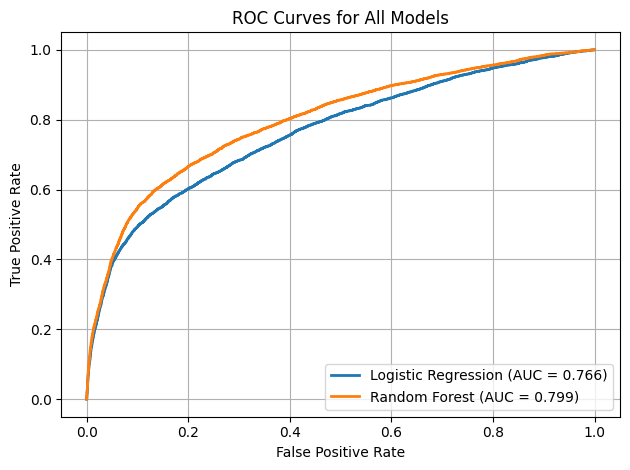

In [ ]:
for name, model in models.items():
    y_true_all = []
    y_prob_all = []

    for train_idx, test_idx in cv_eval.split(X, y):
        est = clone(model)
        est.fit(X.iloc[train_idx], y.iloc[train_idx])

        # Predict probabilities for class 1
        if hasattr(est, "predict_proba"):
            y_prob = est.predict_proba(X.iloc[test_idx])[:, 1]
        elif hasattr(est, "decision_function"):
            y_prob = est.decision_function(X.iloc[test_idx])
        else:
            y_prob = est.predict(X.iloc[test_idx])  # fallback

        y_true_all.append(y.iloc[test_idx])
        y_prob_all.append(y_prob)

    # Concatenate results from all folds
    y_true_concat = np.concatenate(y_true_all)
    y_prob_concat = np.concatenate(y_prob_all)

    fpr, tpr, _ = roc_curve(y_true_concat, y_prob_concat)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.3f})")


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Hoan - GaussianNB

 For the Gaussian Naive Bayes model, feature scaling and one-hot encoding have already been completed, so the remaining step is to determine which features are most important. To accomplish this, the IAMB function is used to identify the features that contribute most effectively to the model.

Gaussian Naive Bayes has very few hyperparameters, so GridSearch is unnecessary. Instead, 5-fold cross-validation is used on the training set to obtain an overall performance estimate. Afterward, the model is trained on the full training split and used to predict the test split. These test-split predictions are then compared with the predictions on the external test file.

In this section, we compare the performance of a model trained on all available features with the performance of a model trained only on the IAMB-selected features to determine which approach yields better results.

### Install Pingouin

In [ ]:
!pip install pingouin

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 6.3 MB/s eta 0:00:00


### IAMB


In [ ]:
# IAMB implementation with partial correlation
# def iamb

# Credited
# https://dev.to/ogambakerubo/feature-selection-with-the-iamb-algorithm-a-casual-dive-into-machine-learning-53a7

import pingouin as pg

def iamb(data, target, alpha=0.05):

  markov_blanket = set()

  # Forward Phase
  for feature in data.columns:
    if feature != target:

      # partial_corr
      # ex:
      #            n         r         CI95%         p-val
      # pearson  768  0.221898  [0.15, 0.29]  5.065127e-10
      #
      # n     - number of valid samples used
      # r     - partial correlations strength
      # CI95% - 95% confidence interval for r
      # p-val - Probability that the observed r occurred by chance if there's no real relationship

      partial_corr  = pg.partial_corr(data=data, x=feature, y=target, covar=markov_blanket)
      p_value       = partial_corr['p-val'].iloc[0]

      # p-value > 0.05 - Could just be randome noise > Ignore feature
      # p-value < 0.05 - Probably meaningful > Keep feature
      if p_value < alpha:
        markov_blanket.add(feature)

  print("Selected Features after Forward Phase :", markov_blanket)

  # Backward Phase
  for feature in list(markov_blanket):
    reduced_mb    = markov_blanket - {feature}
    partial_corr  = pg.partial_corr(data=data, x=feature, y=target, covar=reduced_mb)
    p_value       = partial_corr['p-val'].iloc[0]
    if p_value > alpha:
      markov_blanket.remove(feature)

  print("Selected Features after Backward Phase :", markov_blanket)
  return list(markov_blanket)

### Apply IAMB

In [ ]:
preprocessor_gnb.fit(gnb_X_train)

# Transform
X_train_proc  = preprocessor_gnb.transform(gnb_X_train)
X_test_proc   = preprocessor_gnb.transform(gnb_X_test)

feature_names = preprocessor_gnb.get_feature_names_out()

# Convert to datafram
X_train_proc_df = pd.DataFrame(
  X_train_proc,
  columns=feature_names,
  index=gnb_X_train.index
)

X_test_proc_df = pd.DataFrame(
  X_test_proc,
  columns=feature_names,
  index=gnb_X_test.index
)

# Adding 'y' back
train_proc_with_y       = X_train_proc_df.copy()
train_proc_with_y["y"]  = gnb_y_train

test_proc_with_y        = X_test_proc_df.copy()
test_proc_with_y["y"]   = gnb_y_test


In [ ]:
print("From this many features:", len(X_train_proc_df.columns))
selected_features = iamb(train_proc_with_y, 'y', alpha=0.05)
print("To this many features:", len(selected_features))

From this many features: 47
Selected Features after Forward Phase : {'cat__job_entrepreneur', 'cat__job_management', 'cat__job_blue-collar', 'num__previous', 'cat__contact_telephone', 'num__balance', 'cat__month_jul', 'cat__poutcome_success', 'cat__month_aug', 'cat__education_tertiary', 'cat__month_nov', 'cat__month_mar', 'cat__marital_single', 'cat__month_jun', 'cat__marital_married', 'cat__education_secondary', 'num__day', 'bin__loan', 'cat__job_technician', 'cat__month_sep', 'cat__job_unemployed', 'cat__job_student', 'cat__month_jan', 'cat__job_services', 'bin__housing', 'cat__month_apr', 'cat__month_oct', 'cat__month_may', 'cat__poutcome_failure', 'num__pdays_numeric', 'cat__contact_unknown', 'cat__poutcome_other', 'cat__month_dec', 'cat__poutcome_unknown', 'num__age', 'cat__job_housemaid', 'cat__education_primary', 'cat__job_retired', 'cat__contact_cellular', 'num__campaign'}
Selected Features after Backward Phase : {'cat__contact_telephone', 'num__balance', 'cat__month_jul', 'cat

In [ ]:
# For readability
gnb_X_train_2       = X_train_proc_df
gnb_X_train_IAMB_2  = X_train_proc_df[selected_features]

gnb_X_test_2        = X_test_proc_df
gnb_X_test_IAMB_2   = X_test_proc_df[selected_features]

### GNB Models

In [ ]:
gnb      = GaussianNB()  # All features
gnb_iamb = GaussianNB()  # Selected features

In [ ]:
# CV on TRAIN – GNB
scores_gnb_train = run_cv("gnb", gnb, gnb_X_train_2, gnb_y_train, cv=cv_eval)
print("----------------- GNB 5 fold ---------------------------")
print(pd.DataFrame([scores_gnb_train]))
print()

# CV on TRAIN – GNB + IAMB
scores_gnb_iamb_train = run_cv("gnb_iamb", gnb_iamb, gnb_X_train_IAMB_2, gnb_y_train, cv=cv_eval)
print("----------------- GNB IAMB 5 fold ---------------------------")
print(pd.DataFrame([scores_gnb_iamb_train]))
print()


----------------- GNB 5 fold ---------------------------
  Model Accuracy Mean ± Std   F1 Mean  ± Std AUC-ROC Mean  ± Std
0   gnb     0.8442 ± 0.0087  0.8498 ± 0.0064     0.7388 ± 0.0103

----------------- GNB IAMB 5 fold ---------------------------
      Model Accuracy Mean ± Std   F1 Mean  ± Std AUC-ROC Mean  ± Std
0  gnb_iamb     0.8671 ± 0.0036  0.8632 ± 0.0033     0.7407 ± 0.0085



In [ ]:
print("----------------- GNB INTERNAL TEST SET EVALUATION ---------------------------")
# 1. Fit on full TRAIN
gnb.fit(gnb_X_train_2, gnb_y_train)

# 2. Predict on TEST
y_pred_gnb  = gnb.predict(gnb_X_test_2)
y_proba_gnb = gnb.predict_proba(gnb_X_test_2)  # <-- keep 2D

print_acc_f1_roc(gnb_y_test, y_pred_gnb, y_proba_gnb)

print("----------------- GNB IAMB INTERNAL TEST SET EVALUATION ---------------------------")
# 1. Fit on full TRAIN (IAMB-reduced)
gnb_iamb.fit(gnb_X_train_IAMB_2, gnb_y_train)

# 2. Predict on TEST (IAMB-reduced)
y_pred_gnb_iamb  = gnb_iamb.predict(gnb_X_test_IAMB_2)
y_proba_gnb_iamb = gnb_iamb.predict_proba(gnb_X_test_IAMB_2)  # <-- keep 2D

print_acc_f1_roc(gnb_y_test, y_pred_gnb_iamb, y_proba_gnb_iamb)


----------------- GNB INTERNAL TEST SET EVALUATION ---------------------------
Test Accuracy: 0.8450
Test F1 Score: 0.8505
Test ROC-AUC: 0.7410


Classification report:
               precision    recall  f1-score   support

           0       0.92      0.90      0.91     27945
           1       0.36      0.43      0.39      3702

    accuracy                           0.84     31647
   macro avg       0.64      0.66      0.65     31647
weighted avg       0.86      0.84      0.85     31647

Confusion Matrix:
 [[25156  2789]
 [ 2117  1585]]
----------------- GNB IAMB INTERNAL TEST SET EVALUATION ---------------------------
Test Accuracy: 0.8668
Test F1 Score: 0.8630
Test ROC-AUC: 0.7425


Classification report:
               precision    recall  f1-score   support

           0       0.92      0.93      0.93     27945
           1       0.42      0.37      0.39      3702

    accuracy                           0.87     31647
   macro avg       0.67      0.65      0.66     31647
weight

### External Test

In [ ]:
gnb_EX = gnb_ex_df_test

In [ ]:
gnb_EX_x = gnb_EX.drop(columns="y")
gnb_EX_y = gnb_EX["y"]

In [ ]:
# 1. Transform the new dataset (EX dataset)
X_ex_proc = preprocessor_gnb.transform(gnb_EX_x)

# 2. Convert to DataFrame with correct feature names
X_ex_proc_df = pd.DataFrame(
    X_ex_proc,
    columns=feature_names,      # same names from training transform
    index=gnb_EX_x.index
)


In [ ]:
# For readability
gnb_EX_x_set        = X_ex_proc_df
gnb_EX_x_set_IAMB   = X_ex_proc_df[selected_features]

In [ ]:
print("----------------- GNB EXTERNAL TEST SET EVALUATION ---------------------------")
gnb.fit(gnb_X_train_2, gnb_y_train)
y_pred_gnb_ex  = gnb.predict(gnb_EX_x_set)
y_proba_gnb_ex = gnb.predict_proba(gnb_EX_x_set)
print_acc_f1_roc(gnb_EX_y, y_pred_gnb_ex, y_proba_gnb_ex)

print("----------------- GNB IAMB EXTERNAL TEST SET EVALUATION ---------------------------")
gnb_iamb.fit(gnb_X_train_IAMB_2, gnb_y_train)
y_pred_gnb_iamb_ex  = gnb_iamb.predict(gnb_EX_x_set_IAMB)
y_proba_gnb_iamb_ex = gnb_iamb.predict_proba(gnb_EX_x_set_IAMB)
print_acc_f1_roc(gnb_EX_y, y_pred_gnb_iamb_ex, y_proba_gnb_iamb_ex)

----------------- GNB EXTERNAL TEST SET EVALUATION ---------------------------
Test Accuracy: 0.8394
Test F1 Score: 0.8447
Test ROC-AUC: 0.7168


Classification report:
               precision    recall  f1-score   support

           0       0.92      0.90      0.91      4000
           1       0.33      0.39      0.36       521

    accuracy                           0.84      4521
   macro avg       0.62      0.64      0.63      4521
weighted avg       0.85      0.84      0.84      4521

Confusion Matrix:
 [[3594  406]
 [ 320  201]]
----------------- GNB IAMB EXTERNAL TEST SET EVALUATION ---------------------------
Test Accuracy: 0.8633
Test F1 Score: 0.8583
Test ROC-AUC: 0.7264


Classification report:
               precision    recall  f1-score   support

           0       0.91      0.93      0.92      4000
           1       0.39      0.33      0.36       521

    accuracy                           0.86      4521
   macro avg       0.65      0.63      0.64      4521
weighted a

### Result

In [ ]:
results = [
    ["GNB (5-fold CV)",               0.8442, 0.8498, 0.7388],
    ["GNB IAMB (5-fold CV)",          0.8671, 0.8632, 0.7407],

    ["GNB (Internal Test)",           0.8450, 0.8505, 0.7410],
    ["GNB IAMB (Internal Test)",      0.8668, 0.8630, 0.7425],

    ["GNB (External Test)",           0.8394, 0.8447, 0.7168],
    ["GNB IAMB (External Test)",      0.8633, 0.8583, 0.7264],
]

df_results = pd.DataFrame(
    results,
    columns=["Model", "Accuracy", "F1 Score", "ROC-AUC"]
)

display(df_results)


,Model,Accuracy,F1 Score,ROC-AUC
0,GNB (5-fold CV),0.8442,0.8498,0.7388
1,GNB IAMB (5-fold CV),0.8671,0.8632,0.7407
2,GNB (Internal Test),0.8450,0.8505,0.7410
3,GNB IAMB (Internal Test),0.8668,0.8630,0.7425
4,GNB (External Test),0.8394,0.8447,0.7168
5,GNB IAMB (External Test),0.8633,0.8583,0.7264


Based on the results, the IAMB-selected features consistently improve the Gaussian Naive Bayes model across all evaluation stages — cross-validation, the internal test split, and the external test file. The dataset likely contains correlated or noisy features (as seen in the heatmaps), which Gaussian Naive Bayes struggles with due to its independence assumption. By removing irrelevant and redundant features, IAMB reduces this noise, resulting in a cleaner and more informative feature set. As a result, the IAMB-enhanced model consistently achieves higher scores across all evaluation metrics.